# Detection of Spatial Signatures in Dar es Salaam

This notebook contains complete code required for a detection of spatial signatures in Dar es Salaam, limited by its functional urban area.

This notebook relies on the `gds_env` as its main computational engine, which is deployed on a variety of servers and setups. This means that all the code produced in the project is reproducible under the containers provided in `gds_env`. This notebook uses `gds_py` flavour in a version `6.0`.

For more information on how to run `gds_env`, please visit:

> https://darribas.org/gds_env/

## Contents

- 1. Analysis of form
    - 1.1. Data retrieval
        - 1.1.1. Bulding footprints
        - 1.1.2. Street network
        - 1.1.3. Spatial barriers
    - 1.2. Data pre-processing
        - 1.2.1. Footprints checks and cleaning
        - 1.2.2. Barries checks and cleaning
    - 1.3. Generation of geographies
        - 1.3.1. Enclosures
        - 1.3.2. Enlclosed tessellation
    - 1.4. Morphometric analysis
        - 1.4.1. Primary morphometric characters
        - 1.4.2. Contextualisation
- 2. Analysis of function
    - 2.1. Population
    - 2.2. Land cover
    - 2.3. Night lights
    - 2.4. NDVI
- 3. Cluster analysis
    - 3.1. Form
    - 3.2. Function
    - 3.3. Spatial Signatures
- 4. Figures
- 5. Cluster summary

All packages and custom modules are imported below.

In [1]:
import pickle
import warnings

import dask_geopandas
import geopandas
import geopandas as gpd
import libpysal
import momepy
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import pygeos
import pyrosm
import rasterstats
import rioxarray
import scipy
import utils
import utils.momepy
import xarray
from clustergram import Clustergram
from dask.distributed import Client, LocalCluster
from download import download
from shapely.geometry import box
from sklearn import preprocessing
from sklearn.cluster import KMeans
from tqdm import tqdm
from utils.momepy_utils import (_circle_radius, centroid_corner, elongation,
                                get_corners, get_edge_ratios, get_nodes,
                                solar_orientation_poly, squareness)
from utils.dask_geopandas import dask_dissolve

import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily

Most of our data will be stored as geospatial parquet files, which is currently (Feb 2021) in its intial implementation, but we know that and can filter warnings.

In [2]:
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

First we specify a path to a folder for a data storage.

In [3]:
folder = "../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/"

Case study area is limited by functional urban area (FUA), so let's open all FUAs and filter our polygon.

In [ ]:
fua = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/ghs_fua_2015/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg")

We have to reproject data and clean topology.

In [51]:
fua_4326 = fua.to_crs(4326)
fua_4326.geometry = fua_4326.buffer(0)  # fix geometry topology

In [5]:
des_fua = polygon = fua_4326[fua_4326.eFUA_name == 'Dar es Salaam'].geometry.iloc[0]

## 1. Analysis of form

First step towards spatial signtures is an analysis of urban form to capture its patterns.

### 1.1. Data retrieval

All data used in the work are obtained from open access sources.

#### 1.1.1 Building footprints

Building footprints are obtained from OSM using pyrosm. We first download pbf archive for Tanzania.

In [8]:
%time fp = pyrosm.get_data("tanzania", directory="../../urbangrammar_samba/sp_sig_concept/dar_es_salaam")

Downloaded Protobuf data 'tanzania-latest.osm.pbf' (464.53 MB) to:
'/home/jovyan/work/urbangrammar_samba/sp_sig_concept/dar_es_salaam/tanzania-latest.osm.pbf'
CPU times: user 1.42 s, sys: 1.77 s, total: 3.19 s
Wall time: 16.6 s


In [6]:
fp = '/home/jovyan/work/urbangrammar_samba/sp_sig_concept/dar_es_salaam/tanzania-latest.osm.pbf'

Then we load pbf to pyrosm.

In [7]:
%time osm = pyrosm.OSM(fp)

CPU times: user 1.74 ms, sys: 658 µs, total: 2.4 ms
Wall time: 10.1 ms


And extract all buildings.

In [15]:
%time buildings = osm.get_buildings()

CPU times: user 8min 48s, sys: 37.1 s, total: 9min 25s
Wall time: 9min 21s


Finally, we filter those within our FUA.

In [16]:
%time dar = buildings.iloc[buildings.sindex.query(des_fua, predicate='intersects')]

CPU times: user 13.3 s, sys: 594 ms, total: 13.9 s
Wall time: 13.9 s


Then we reproject it and save to a file.

In [ ]:
dar = dar.to_crs(gdf.crs)

In [19]:
dar[['building', 'building:levels', 'geometry']].to_parquet(folder + 'footprints_osm.pq')

#### 1.1.2 Street network

Street network is obtined from OSM using OSMnx, and custom tags.

We get a graph, project it, turn into undirected one and export to GeoDataFrame. Then we make sure `highway` parameter is string and can be saved to file.

In [7]:
%%time
type_filter = '["highway"~"living_street|motorway|motorway_link|pedestrian|primary|primary_link|residential|secondary|secondary_link|service|tertiary|tertiary_link|trunk|trunk_link"]'

streets_graph = ox.graph_from_polygon(polygon, network_type='all_private', custom_filter=type_filter, retain_all=True)
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.highway = gdf.highway.astype(str)
path = folder + 'roads_osm.pq'
gdf[['highway', 'geometry']].to_parquet(path)

CPU times: user 2min 25s, sys: 1.27 s, total: 2min 26s
Wall time: 2min 42s


#### 1.1.3. Spatial barriers

Identification of enclosures should optimally contain variety of barriers, not only street networks. Therefore, we download railway and water geometry from OSM.

##### Water

In [ ]:
%%time
tags = {'natural': ['water', 'coastline', 'spring']}
gdf = ox.geometries_from_polygon(des_fua, tags)
path = folder + 'water_osm.pq'
gdf[['natural', 'geometry']].to_parquet(path)

##### Railway

Then we get railway and filter out proper geometry type (we want LineStrings representing railway tracks).

In [ ]:
%%time
tags = {'railway': True}
gdf = ox.geometries_from_polygon(des_fua, tags)
path = folder + 'railway_osm.pq'
gdf[['railway', 'geometry']].to_parquet(path)

### 1.2. Data pre-processing

Before we can analyse form using the data we just downloaded, we need to ensure that they are in a proper form.

#### 1.2.1. Footprints checks and cleaning

Let's start with building footprints.

In [4]:
buildings = gpd.read_parquet(folder + 'footprints_osm.pq')

OSM data tend to be messy, so we need to check validity and geometry types.

In [5]:
buildings.geom_type.value_counts()

Polygon            1161335
MultiLineString         96
MultiPolygon            20
LineString               9
dtype: int64

We explode geometries and keep only polygons.

In [9]:
buildings = buildings.reset_index(drop=True).explode().reset_index(drop=True)
buildings = buildings[buildings.geom_type == 'Polygon']

We can then use `momepy.CheckTessellationInput()` class to check for potential issues which may arise during enclosed tessellation.

In [10]:
%time check = momepy.CheckTessellationInput(buildings)

Collapsed features  : 572
Split features      : 419
Overlapping features: 154
CPU times: user 1min 27s, sys: 2.1 s, total: 1min 29s
Wall time: 1min 27s


In the ideal case, we should fix overlapping geometry. For the sake of examples, that is not necessary and we may drop them as well as buildings which would collapse.

In [11]:
buildings = buildings.drop(check.collapse.index.union(check.overlap.index))

In [12]:
buildings.shape

(1160654, 3)

We have to clean topology.

In [60]:
buildings.is_valid.all()

False

In [61]:
buildings.geometry = buildings.buffer(0)

In [62]:
buildings.is_valid.all()

True

This results in 1 160 654 cleaned buildings. We will assign unique ID to each of them and save them to a file.

In [13]:
buildings["uID"] = range(len(buildings))
%time buildings.to_parquet(folder + "buildings.pq")

CPU times: user 2.04 s, sys: 243 ms, total: 2.28 s
Wall time: 3.36 s


#### 1.2.2. Barries checks and cleaning

Let's now check our barriers and close potential unwanted gaps to generate clean enclosures

In [41]:
roads = gpd.read_parquet(folder + "roads_osm.pq").to_crs(buildings.crs)

In [42]:
roads.geom_type.unique()

array(['LineString'], dtype=object)

In [43]:
railway = gpd.read_parquet(folder + 'railway_osm.pq').to_crs(buildings.crs)

In [44]:
railway.geom_type.unique()

array(['Point', 'LineString', 'Polygon'], dtype=object)

In [45]:
railway = railway[railway.geom_type == 'LineString']

Roads seems to be fine, railway required geometry type filtering. The only other step we do is extension of railway lines to snap to roads.

In [46]:
extended_railway = utils.momepy.extend_lines(railway, 30, target=roads, extension=.1)

In [47]:
water = gpd.read_parquet(folder + "water_osm.pq").to_crs(buildings.crs)

In [48]:
coastline = water[water.geom_type =='LineString']

### 1.3. Generation of geographies

Now we have to create geographies we will be using in the analysis. Enclosures and enclosed tessellation.

#### 1.3.1. Enclosures

Enclosures require spatial barriers, which are roads, water and railway (we use the extended one we did above), limited by FUA.

In [55]:
des_fua = fua_4326.to_crs(buildings.crs)[fua_4326.eFUA_name == 'Dar es Salaam']

In [56]:
%%time
enclosures = utils.momepy.enclosures(roads, limit=des_fua, additional_barriers=[extended_railway, coastline])

CPU times: user 9.17 s, sys: 2.16 ms, total: 9.17 s
Wall time: 9.17 s


In [63]:
enclosures.is_valid.all()

True

#### 1.3.2. Enclosed tessellation

With enclosures and buildings, we can now create enclosed tessellation.

In [64]:
%%time
tess = utils.momepy.Tessellation(buildings, 'uID', enclosures=enclosures)

CPU times: user 8h 10min 33s, sys: 39min 38s, total: 8h 50min 11s
Wall time: 3h 14min 31s


Finally, we can save both newly generated geographies to files.

In [65]:
tess.tessellation.to_parquet(folder + "tessellation.pq")

In [66]:
enclosures.to_parquet(folder + "enclosures.pq")

### 1.4. Morphometric analysis

Morpohmetric analysis first measures primary characters, which are then contextualised to capture the tendencies within the local context of each tessellation cell.

#### 1.4.1. Primary morphometric characters

For the analysis we need four input layer representing urban form - buildings, streets, enclosed tessellation and enclosures.

In [3]:
tess = gpd.read_parquet(folder + "tessellation.pq")
enclosures = gpd.read_parquet(folder + "enclosures.pq")
buildings = gpd.read_parquet(folder + "buildings.pq")

In many cases, we will need to relate buildings to tessellation cells. the best way to ensure the proper linkage is to combine both GeoDataFrames into a single one with two named geometry columns. Then we can assign unique ID to each tessellation cell. Remember that not every cell has assigned a building.

In [4]:
tess = tess.rename_geometry("tessellation").merge(
    blg[["uID", "geometry"]].rename_geometry("buildings"), on="uID", how="left"
)

In [5]:
tess['tID'] = range(len(tess))
tess.head(5)

uID                                       tessellation  eID  \
0  784070.0  POLYGON ((530753.667 -751662.183, 530753.915 -...    0   
1  785052.0  POLYGON ((530753.915 -751662.504, 530753.667 -...    0   
2  785854.0  POLYGON ((530710.355 -751642.103, 530709.850 -...    0   
3  786074.0  POLYGON ((530709.663 -751625.639, 530708.164 -...    0   
4  786327.0  POLYGON ((530744.095 -751637.861, 530744.095 -...    0   

                                           buildings  tID  
0  POLYGON ((530671.226 -751656.231, 530671.497 -...    0  
1  POLYGON ((530746.821 -751631.899, 530756.257 -...    1  
2  POLYGON ((530680.755 -751609.597, 530694.811 -...    2  
3  POLYGON ((530696.687 -751613.442, 530705.825 -...    3  
4  POLYGON ((530727.804 -751594.126, 530743.086 -...    4

In [6]:
tess.shape

(1168896, 5)

The GeoDataFrame is large (1.17 million tessellation cells), therefore we try to paralellise as much as we can. For that, we use dask-geopandas, which is an attempt to parallelize GeoPandas usign dask.dataframe and distributed computation with Dask. As of February '21, dask-geopandas is still in alpha version but as you will see, we can already do a lot.

To have a better control over local dask cluster, we can create one manually (note that the machine we use has 16 cores).

In [8]:
client = Client(LocalCluster(n_workers=16))
client

<Client: 'tcp://127.0.0.1:44957' processes=16 threads=16, memory=134.91 GB>

In [9]:
warnings.filterwarnings('ignore', message='.*Assigning CRS to a GeoDataFrame without a geometry*')  # temporary silence due to a rough edge

We create dask.GeoDataFrame from our geodataframe with number of partitions equal to number of workers in a cluster.

In [10]:
ddf = dask_geopandas.from_geopandas(tess, npartitions=16)

You may see in other notebooks in this project, that the following section is using `momepy` to measure morphometric characters. The following cell contains the same functions, just written for dask (momepy works with pure GeoPandas). Refer to the [documentation of momepy](https://docs.momepy.org) for details on each one of them. Each result is assigned as a new column.

In [11]:
%%time
## Measure morphometric characters
# Building area
ddf['sdbAre'] = ddf.buildings.area

# Building perimeter
ddf['sdbPer'] = ddf.buildings.length

# Courtyard area
exterior_area = ddf.buildings.map_partitions(lambda series: pygeos.area(pygeos.polygons(series.exterior.values.data)), meta='float')
ddf['sdbCoA'] = exterior_area - ddf['sdbAre']

# Circular compactness
hull = ddf.buildings.convex_hull.exterior

radius = hull.apply(lambda g: _circle_radius(list(g.coords)) if g is not None else None, meta='float')
ddf['ssbCCo'] = ddf['sdbAre'] / (np.pi * radius ** 2)

# Corners
ddf['ssbCor'] = ddf.buildings.apply(lambda g: get_corners(g), meta='float')

# Squareness
ddf['ssbSqu'] = ddf.buildings.apply(lambda g: squareness(g), meta='float')

# Equivalent rectangular index
bbox = ddf.buildings.apply(lambda g: g.minimum_rotated_rectangle if g is not None else None, meta=geopandas.GeoSeries())
ddf['ssbERI'] = (ddf['sdbAre'] / bbox.area).pow(1./2) * (bbox.length / ddf['sdbPer'])

# Elongation
ddf['ssbElo'] = bbox.map_partitions(lambda s: elongation(s), meta='float')

# Centroid corner mean distance and deviation
def _centroid_corner(series):
    ccd = series.apply(lambda g: centroid_corner(g))
    return pd.DataFrame(ccd.to_list(), index=series.index)


ddf[['ssbCCM', 'ssbCCD']] = ddf.buildings.map_partitions(_centroid_corner, meta=pd.DataFrame({0: [0.1], 1: [1.1]}))

# Solar orientation
ddf['stbOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Tessellation longest axis length
hull = ddf.tessellation.convex_hull.exterior

ddf['sdcLAL'] = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float') * 2

# Tessellation area
ddf['sdcAre'] = ddf.tessellation.area

# Circular compactness
radius = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float')
ddf['sscCCo'] = ddf['sdcAre'] / (np.pi * radius ** 2)

# Equivalent rectangular index
bbox = ddf.tessellation.apply(lambda g: g.minimum_rotated_rectangle, meta=geopandas.GeoSeries())
ddf['sscERI'] = (ddf['sdcAre'] / bbox.area).pow(1./2) * (bbox.length / ddf.tessellation.length)

# Solar orientation
ddf['stcOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Covered area ratio
ddf['sicCAR'] = ddf['sdbAre'] / ddf['sdcAre']

# Building-cell alignment
ddf['stbCeA'] = (ddf['stbOri'] - ddf['stcOri']).abs()

# Compute all characters using dask
df = ddf.compute()

CPU times: user 46.5 s, sys: 10.8 s, total: 57.2 s
Wall time: 7min 2s


We can save our intermediate result to a parquet.

In [13]:
df.to_parquet(folder + "tess.pq")

Now we use the same approach to measure characters on enclosures.

In [20]:
%%time
# Load data
encl = dask_geopandas.from_geopandas(enclosures, npartitions=16)

# Area
encl['ldeAre'] = encl.geometry.area

# Perimeter
encl['ldePer'] = encl.geometry.length

# Circular compacntess
hull = encl.geometry.convex_hull.exterior

radius = hull.apply(lambda g: _circle_radius(list(g.coords)) if g is not None else None, meta='float')
encl['lseCCo'] = encl['ldeAre'] / (np.pi * radius ** 2)

# Equivalent rectangular index
bbox = encl.geometry.apply(lambda g: g.minimum_rotated_rectangle if g is not None else None, meta=geopandas.GeoSeries())
encl['lseERI'] = (encl['ldeAre'] / bbox.area).pow(1./2) * (bbox.length / encl['ldePer'])

# Compactness-weighted axis
longest_axis = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float') * 2
encl['lseCWA'] = longest_axis * ((4 / np.pi) - (16 * encl['ldeAre']) / ((encl['ldePer']) ** 2))

# Solar orientation
encl['lteOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Compute data and return geopandas.GeoDataFrame
encl_df = encl.compute()

# Weighted number of neighbors
inp, res = encl_df.sindex.query_bulk(encl_df.geometry, predicate='intersects')
indices, counts = np.unique(inp, return_counts=True)
encl_df['neighbors'] = counts - 1
encl_df['lteWNB'] = encl_df['neighbors'] / encl_df['ldePer']

# Measure weighted cells within enclosure
encl_counts = tess.groupby('eID').count()
merged = encl_df[['eID', 'ldeAre']].merge(encl_counts[['tessellation']], how='left', on='eID')
encl_df['lieWCe'] = merged['tessellation'] / merged['ldeAre']

CPU times: user 17.1 s, sys: 8.49 ms, total: 17.1 s
Wall time: 17 s


In [22]:
# Save data to parquet
encl_df.to_parquet(folder + "enclosures.pq")

Some functions are hard to parallelize. Those are measured directly on the whole dataset using GeoPandas.

In [3]:
cells = gpd.read_parquet(folder + "tess.pq")

Some of the characters require spatial weights matrices. We can generate Queen contiguity based on enclosed tessellation. Characters often require specification of immediate context. In our case, we use the inlcusive third order contiguity, which can be easily generated based on the intial Queen contiguity.

We then save both to files.

In [ ]:
%time w = libpysal.weights.Queen.from_dataframe(cells, geom_col='tessellation')
%time w3 = momepy.sw_high(k=3, weights=w)

In [8]:
%time scipy.sparse.save_npz(folder + "w_queen.npz", w.sparse)
%time scipy.sparse.save_npz(folder + "w3_queen.npz", w3.sparse)

CPU times: user 2.19 s, sys: 8.08 ms, total: 2.2 s
Wall time: 2.37 s
CPU times: user 21 s, sys: 40.1 ms, total: 21.1 s
Wall time: 21.4 s


The following could be measured directly using momepy as well.

In [10]:
df = cells

In [ ]:
# alignment
def alignment(x, orientation="stbOri"):
    orientations = df[orientation].iloc[w.neighbors[x]]
    return abs(orientations - df[orientation].iloc[x]).mean()


df["mtbAli"] = [alignment(x) for x in range(len(df))]

# mean neighbour distance
def neighbor_distance(x):
    geom = df.buildings.iloc[x]
    if geom is None:
        return np.nan
    return df.buildings.iloc[w.neighbors[x]].distance(df.buildings.iloc[x]).mean()


df["mtbNDi"] = [neighbor_distance(x) for x in range(len(df))]

# weighted neighbours
df["mtcWNe"] = (
    pd.Series([w.cardinalities[x] for x in range(len(df))], index=df.index)
    / df.tessellation.length
)

# area covered by neighbours
def area_covered(x, area="sdcAre"):
    neighbours = [x]
    neighbours += w.neighbors[x]

    return df[area].iloc[neighbours].sum()


df["mdcAre"] = [area_covered(x) for x in range(len(df))]

# read W3

# weighted reached enclosures
def weighted_reached_enclosures(x, area="sdcAre", enclosure_id="eID"):
    neighbours = [x]
    neighbours += w3.neighbors[x]

    vicinity = df[[area, enclosure_id]].iloc[neighbours]

    return vicinity[enclosure_id].unique().shape[0] / vicinity[area].sum()


df["ltcWRE"] = [weighted_reached_enclosures(x) for x in range(len(df))]

# mean interbuilding distance
# define adjacency list from lipysal
adj_list = w.to_adjlist(remove_symmetric=False)
adj_list["weight"] = (
    df.buildings.iloc[adj_list.focal]
    .reset_index(drop=True)
    .distance(df.buildings.iloc[adj_list.neighbor].reset_index(drop=True))
    .values
)


In [ ]:
# interbuilding distance
G = nx.from_pandas_edgelist(
        adj_list, source="focal", target="neighbor", edge_attr="weight"
    )
ibd = []
for i in range(len(df)):
    try:
        sub = nx.ego_graph(G, i, radius=3)
        ibd.append(np.nanmean([x[-1] for x in list(sub.edges.data('weight'))]))
    except:
        ibd.append(np.nan)

df['ltbIBD'] = ibd

# Reached neighbors and area on 3 topological steps on tessellation
df['ltcRea'] = [w3.cardinalities[i] for i in range(len(df))]
df['ltcAre'] = [df.sdcAre.iloc[w3.neighbors[i]].sum() for i in range(len(df))]

# Save cells to parquet keeping only within-chunk data not the additional neighboring
df.to_parquet(folder + "tess.pq")

# Load street network for an extended chunk area
streets = gpd.read_parquet(folder + "roads_osm.pq").to_crs(df.crs)

In [ ]:
# Street profile (measures width, width deviation and openness)
sp = momepy.StreetProfile(streets, df.set_geometry('buildings').buffer(0))
streets['sdsSPW'] = sp.w
streets['sdsSWD'] = sp.wd
streets['sdsSPO'] = sp.o

# Street segment length
streets['sdsLen'] = streets.length

# Street segment linearity
streets['sssLin'] = momepy.Linearity(streets).series

# Convert geopadnas.GeoDataFrame to networkx.Graph for network analysis
G = momepy.gdf_to_nx(streets)

# Node degree
G = momepy.node_degree(G)

# Subgraph analysis (meshedness, proportion of 0, 3 and 4 way intersections, local closeness)
G = momepy.subgraph(
    G,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
    verbose=False
)

# Cul-de-sac length
G = momepy.cds_length(G, radius=3, name="ldsCDL", verbose=False)

# Square clustering
G = momepy.clustering(G, name="xcnSCl")

# Mean node distance
G = momepy.mean_node_dist(G, name="mtdMDi", verbose=False)

# Convert networkx.Graph back to GeoDataFrames and W (denoting relationships between nodes)
nodes, edges, sw = momepy.nx_to_gdf(G, spatial_weights=True)

# Generate inclusive higher order weights
edges_w3 = momepy.sw_high(k=3, gdf=edges)

# Mean segment length
edges["ldsMSL"] = momepy.SegmentsLength(edges, spatial_weights=edges_w3, mean=True, verbose=False).series

# Generate inclusive higher order weights
nodes_w5 = momepy.sw_high(k=5, weights=sw)

# Node density
nodes["lddNDe"] = momepy.NodeDensity(nodes, edges, nodes_w5, verbose=False).series

# Weighter node density
nodes["linWID"] = momepy.NodeDensity(nodes, edges, nodes_w5, weighted=True, node_degree="degree", verbose=False).series

# Save to parquets
edges.to_parquet(folder + "edges.pq")
nodes.to_parquet(folder + "nodes.pq")

In [20]:
cells = df

We also need to link tessellation cells to streets. We do it based on intersection. The following gives us the ratio if the tessellation intersects more than one cell.

In [ ]:
cells['edgeID'] = get_edge_ratios(cells, edges)
cells['nodeID'] = get_nodes(cells, nodes, edges, 'nodeID', 'edgeID', 'node_start', 'node_end')

characters = ['sdsSPW', 'sdsSWD', 'sdsSPO', 'sdsLen', 'sssLin', 'ldsMSL']
l = []
for d in cells.edgeID:
    l.append((edges.iloc[list(d.keys())][characters].multiply(list(d.values()), axis='rows')).sum(axis=0))
cells[characters] = pd.DataFrame(l, index=cells.index)

cells = cells.merge(nodes.drop(columns=['geometry']), on='nodeID', how='left')
cells = cells.rename({'degree': 'mtdDeg', 'meshedness': 'lcdMes', 'proportion_3': 'linP3W', 'proportion_4': 'linP4W',
                 'proportion_0': 'linPDE', 'local_closeness': 'lcnClo'}, axis='columns')

cells['edgeID_keys'] = cells.edgeID.apply(lambda d: list(d.keys()))
cells['edgeID_values'] = cells.edgeID.apply(lambda d: list(d.values()))

cells.drop(columns='edgeID').to_parquet(folder + "tess.pq")


In [3]:
enclosures = gpd.read_parquet(folder + "enclosures.pq")
cells = gpd.read_parquet(folder + "tess.pq")
nodes = gpd.read_parquet(folder + "nodes.pq")
edges = gpd.read_parquet(folder + "edges.pq")

In [4]:
cells = cells.merge(enclosures.drop(columns=['neighbors']), on='eID', how='left')

In [5]:
# Street Alignment
edges['orient'] = momepy.Orientation(edges, verbose=False).series
edges['edgeID'] = range(len(edges))
keys = cells.edgeID_values.apply(lambda a: np.argmax(a))
cells['edgeID_primary'] = [inds[i] for inds, i in zip(cells.edgeID_keys, keys)]
cells['stbSAl'] = momepy.StreetAlignment(cells, 
                                         edges, 
                                         'stbOri', 
                                         left_network_id='edgeID_primary', 
                                         right_network_id='edgeID').series

# Area Covered by each edge
vals = {x:[] for x in range(len(edges))}
for i, keys in enumerate(cells.edgeID_keys):
    for k in keys:
        vals[k].append(i)
area_sums = []
for inds in vals.values():
    area_sums.append(cells.sdcAre.iloc[inds].sum())
edges['sdsAre'] = area_sums

# Building per meter
bpm = []
for inds, l in zip(vals.values(), edges.sdsLen):
    bpm.append(cells.buildings.iloc[inds].notna().sum() / l if len(inds) > 0 else 0)
edges['sisBpM'] = bpm

# Cell area
nodes['sddAre'] = nodes.nodeID.apply(lambda nid: cells[cells.nodeID == nid].sdcAre.sum())

In [ ]:
# Area covered by neighboring edges + count of reached cells
edges_W = libpysal.weights.Queen.from_dataframe(edges, silence_warnings=True)

areas = []
reached_cells = []
for i in range(len(edges)):
    neighbors = [i] + edges_W.neighbors[i]
#     areas
    areas.append(edges.sdsAre.iloc[neighbors].sum())
#     reached cells
    ids = []
    for n in neighbors:
         ids += vals[n]
    reached_cells.append(len(set(ids)))

edges['misCel'] = reached_cells
edges['mdsAre'] = areas

# Area covered by neighboring (3 steps) edges + count of reached cells
edges_W3 = momepy.sw_high(k=3, weights=edges_W)

areas = []
reached_cells = []
for i in range(len(edges)):
    neighbors = [i] + edges_W3.neighbors[i]
#     areas
    areas.append(edges.sdsAre.iloc[neighbors].sum())
#     reached cells
    ids = []
    for n in neighbors:
         ids += vals[n]
    reached_cells.append(len(set(ids)))

edges['lisCel'] = reached_cells
edges['ldsAre'] = areas

# Link together 
e_to_link = ['sdsAre', 'sisBpM', 'misCel', 'mdsAre', 'lisCel', 'ldsAre']
n_to_link = 'sddAre'

cells = cells.merge(nodes[['nodeID', 'sddAre']], on='nodeID', how='left')

l = []
for keys, values in zip(cells.edgeID_keys, cells.edgeID_values):
    l.append((edges.iloc[keys][e_to_link].multiply(values, axis='rows')).sum(axis=0))  # weighted by the proportion
cells[e_to_link] = pd.DataFrame(l, index=cells.index)

Now that we have all chracters measured and linked together, we can save all to parquet file.

In [12]:
cells.to_parquet(folder + "tess.pq")

In [10]:
edges.columns

Index(['highway', 'geometry', 'sdsSPW', 'sdsSWD', 'sdsSPO', 'sdsLen', 'sssLin',
       'mm_len', 'cdsbool', 'node_start', 'node_end', 'ldsMSL', 'orient',
       'edgeID', 'sdsAre', 'sisBpM', 'misCel', 'mdsAre', 'lisCel', 'ldsAre'],
      dtype='object')

In [11]:
cells.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'sdbAre', 'sdbPer',
       'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM',
       'ssbCCD', 'stbOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'stcOri',
       'sicCAR', 'stbCeA', 'mtbAli', 'mtbNDi', 'mtcWNe', 'mdcAre', 'ltcWRE',
       'ltbIBD', 'ltcRea', 'ltcAre', 'nodeID', 'sdsSPW', 'sdsSWD', 'sdsSPO',
       'sdsLen', 'sssLin', 'ldsMSL', 'mtdDeg', 'lcdMes', 'linP3W', 'linP4W',
       'linPDE', 'lcnClo', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID',
       'edgeID_keys', 'edgeID_values', 'geometry', 'ldeAre', 'ldePer',
       'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe',
       'edgeID_primary', 'stbSAl', 'sddAre', 'sdsAre', 'sisBpM', 'misCel',
       'mdsAre', 'lisCel', 'ldsAre'],
      dtype='object')

#### 1.4.2. Contextualisation

Cluster analysis needs to be performant on large datasets, therefore it should not contain spatial constraints (such algorithms do not scale well). At the same time, we are interested in the tendency of characters within the area. Most primary characters are local only, with minimal or no sense of context. Therefore, we do the contextualisation of each primary character to get the first, second and third quartile of the distribution of values within inclusive 10th order of contiguity around each tessellation cell, weighted by the inverse distance between cell's centroids.

First we need to load the data (unless they are still in memory from the steps above).

In [4]:
characters = [
    "sdbAre",
    "sdbPer",
    "sdbCoA",
    "ssbCCo",
    "ssbCor",
    "ssbSqu",
    "ssbERI",
    "ssbElo",
    "ssbCCM",
    "ssbCCD",
    "stbOri",
    "sdcLAL",
    "sdcAre",
    "sscCCo",
    "sscERI",
    "stcOri",
    "sicCAR",
    "stbCeA",
    "mtbAli",
    "mtbNDi",
    "mtcWNe",
    "mdcAre",
    "ltcWRE",
    "ltbIBD",
    "ltcRea",
    "ltcAre",
    "sdsSPW",
    "sdsSWD",
    "sdsSPO",
    "sdsLen",
    "sssLin",
    "ldsMSL",
    "mtdDeg",
    "lcdMes",
    "linP3W",
    "linP4W",
    "linPDE",
    "lcnClo",
    "ldsCDL",
    "xcnSCl",
    "mtdMDi",
    "lddNDe",
    "linWID",
    "ldeAre",
    "ldePer",
    "lseCCo",
    "lseERI",
    "lseCWA",
    "lteOri",
    "lteWNB",
    "lieWCe",
    "stbSAl",
    "sddAre",
    "sdsAre",
    "sisBpM",
    "misCel",
    "mdsAre",
    "lisCel",
    "ldsAre",
]

In [4]:
%%time 
data = gpd.read_parquet(
    folder + "tess.pq", columns=characters + ["tessellation", "tID"]
)

CPU times: user 12.6 s, sys: 7.45 s, total: 20.1 s
Wall time: 39.9 s


In [5]:
bounds = data.total_bounds

In [6]:
data = data.set_index("tID")

In [7]:
tid = pd.Series(index=data.index, dtype="object", name="division")

Due to the extent of the data and memory demands, we are splitting the df into five parts.

In [8]:
centroids = data.centroid

In [9]:
x = np.mean([bounds[0], bounds[2]]) + 10000
y = np.mean([bounds[1], bounds[3]]) - 5000

First we split into four quadrants.

In [10]:
sw = centroids.cx[:x, :y]
se = centroids.cx[x:, :y]
nw = centroids.cx[:x, y:]
ne = centroids.cx[x:, y:]

Then we further split the largest quadrant into two.

In [20]:
ne_bounds = ne.total_bounds
div = np.mean([ne_bounds[0], ne_bounds[2]]) - 5000
ne_a = ne.cx[:div, :]
ne_b = ne.cx[div:, :]

And we assign chunk identifiers to a Series for storage.

In [21]:
tid.loc[sw.index] = "sw"
tid.loc[se.index] = "se"
tid.loc[nw.index] = "nw"
tid.loc[ne_a.index] = "ne_a"
tid.loc[ne_b.index] = "ne_b"

In [22]:
tid.value_counts()

se      366589
nw      290483
ne_b    225568
sw      153615
ne_a    132641
Name: division, dtype: int64

We save chunking to a file.

In [23]:
pd.DataFrame(tid).to_parquet(folder + "chunks.pq")

Now we split our data into overlapping chunks. These has to overlap to keep the necessary information on the chunk edges.

In [24]:
%%time
data.cx[:x + 1000, :y + 1000].to_parquet(folder + "sw.pq")
data.cx[x - 1000:, :y + 1000].to_parquet(folder + "se.pq")
data.cx[:x + 1000, y - 1000:].to_parquet(folder + "nw.pq")
data.cx[x - 1000:, y - 1000:].cx[:div + 1000, :].to_parquet(folder + "ne_a.pq")
data.cx[x - 1000:, y - 1000:].cx[div - 1000:, :].to_parquet(folder + "ne_b.pq")

CPU times: user 9.77 s, sys: 2.15 s, total: 11.9 s
Wall time: 20.8 s


Then we can loop over chunks and their GeoDataFrames and measure contextualisation of each character.

In [7]:
for chunk in ["sw", "se", "nw", "ne_a", "ne_b"]: 
    gdf = gpd.read_parquet(folder + f"{chunk}.pq")
    W = momepy.sw_high(k=10, weights=libpysal.weights.Queen.from_dataframe(gdf, geom_col="tessellation"))
    gdf.geometry = gdf.centroid
    
    convolutions = {}
    for c in characters:
        convolutions[c] = []

    # measure convolutions
    for i, geom in tqdm(enumerate(gdf.geometry), total=gdf.shape[0]):
        neighbours = W.neighbors[i]
        vicinity = gdf.iloc[neighbours]
        distance = vicinity.distance(geom)
        distance_decay = (1 / distance).replace(np.inf, 0)  # to filter out duplications

        for c in characters:
            values = vicinity[c].values
            sorter = np.argsort(values)
            values = values[sorter]
            nan_mask = np.isnan(values)
            if nan_mask.all():
                convolutions[c].append(np.array([np.nan] * 3))
            else:
                sample_weight = distance_decay.values[sorter][~nan_mask]
                weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
                weighted_quantiles /= np.sum(sample_weight)
                interpolate = np.interp([.25, .5, .75], weighted_quantiles, values[~nan_mask])
                convolutions[c].append(interpolate)
    
    conv = pd.DataFrame(convolutions, index=gdf.index)
    exploded = pd.concat([pd.DataFrame(conv[c].to_list(), columns=[c + '_q1', c + '_q2',c + '_q3']) for c in characters], axis=1)
    exploded.to_parquet(folder + f"convolutions_{chunk}.pq")
    print(f"{chunk} done.")

100%|██████████| 184220/184220 [16:10<00:00, 189.73it/s]


sw done.


100%|██████████| 430724/430724 [39:28<00:00, 181.84it/s] 


se done.


100%|██████████| 332748/332748 [31:05<00:00, 178.33it/s] 


nw done.


100%|██████████| 228660/228660 [22:46<00:00, 167.30it/s] 


ne_a done.


100%|██████████| 291882/291882 [33:10<00:00, 146.63it/s] 


ne_b done.


Once done, we can load all results and merge them together based on intial rechunking.

In [8]:
chunks = pd.read_parquet(folder + "chunks.pq")

In [9]:
sw = pd.read_parquet(folder + "convolutions_sw.pq")
se = pd.read_parquet(folder + "convolutions_se.pq")
nw = pd.read_parquet(folder + "convolutions_nw.pq")
ne_a = pd.read_parquet(folder + "convolutions_ne_a.pq")
ne_b = pd.read_parquet(folder + "convolutions_ne_b.pq")

In [10]:
sw_gdf = pd.read_parquet(folder + "sw.pq", columns=["tID"])

In [11]:
sw.index = sw_gdf.index

In [12]:
se_gdf = pd.read_parquet(folder + "se.pq", columns=["tID"])
nw_gdf = pd.read_parquet(folder + "nw.pq", columns=["tID"])
ne_a_gdf = pd.read_parquet(folder + "ne_a.pq", columns=["tID"])
ne_b_gdf = pd.read_parquet(folder + "ne_b.pq", columns=["tID"])

se.index = se_gdf.index
nw.index = nw_gdf.index
ne_a.index = ne_a_gdf.index
ne_b.index = ne_b_gdf.index

In [13]:
sw = sw.loc[sw.index.isin(chunks[chunks.division == "sw"].index)]
se = se.loc[se.index.isin(chunks[chunks.division == "se"].index)]
nw = nw.loc[nw.index.isin(chunks[chunks.division == "nw"].index)]
ne_a = ne_a.loc[ne_a.index.isin(chunks[chunks.division == "ne_a"].index)]
ne_b = ne_b.loc[ne_b.index.isin(chunks[chunks.division == "ne_b"].index)]

Finally, we sort data acoording to an ID and save to a file.

In [14]:
convolutions = pd.concat([sw, se, nw, ne_a, ne_b]).sort_index()

In [19]:
convolutions.to_parquet(folder + "convolutions.pq")

## 2. Analysis of function

Next we want to characterise built environemnt by its function.

### 2.1. Population

We use WorldPop gridded population estimates (https://www.worldpop.org/geodata/summary?id=6320).

In [4]:
download("https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/TZA/tza_ppp_2020.tif",
        folder + "population/tza_ppp_2020.tif")


file_sizes: 100%|████████████████████████████| 485M/485M [00:44<00:00, 10.8MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/population/tza_ppp_2020.tif


'../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/population/tza_ppp_2020.tif'

In [13]:
data = gpd.read_parquet(folder + "tess.pq",
                        columns=["tessellation", "tID"]
                        )

We open file.

In [4]:
pop = xarray.open_rasterio(folder + 'population/tza_ppp_2020.tif')

We have a raster covering the whole country. We reproject data and clip to the extent of tessellation.

In [ ]:
pop_proj = pop.rio.reproject(data.crs)
pop_clip = pop_proj.rio.clip_box(*data.total_bounds)

In [7]:
pop_clip.rio.to_raster(folder + 'population/tza_ppp_2020_proj.tif')

Now we get an array and affine transformation which we pass to zonal statistics.

In [8]:
arr = pop_clip.values
affine = pop_clip.rio.transform()

In [9]:
%%time 
stats = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
)

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


CPU times: user 15min 56s, sys: 33.7 s, total: 16min 30s
Wall time: 16min 30s


Then we can link mean values to tessellation data.

In [10]:
data['population'] = [x['mean'] for x in stats]

In [ ]:
mask = data.population < 0
data.population[mask] = 0

In [13]:
data[['tID', 'population']].to_parquet(folder + "population/population.pq")

### 2.2. Land cover

We use Land Cover from Copernicus Global Land Service (https://land.copernicus.eu/global/products/lc). It is a grid in a 100m resolution.

In [14]:
download("https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2019/E020N00/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif",
         folder + "land_cover/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif")


file_sizes: 100%|██████████████████████████| 95.6M/95.6M [00:03<00:00, 31.3MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/land_cover/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif


'../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/land_cover/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif'

We open, reproject and clip the data to the extent of tessellation bounds.

In [3]:
lc = xarray.open_rasterio(folder + 'land_cover/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif')

In [ ]:
lc_proj = lc.rio.reproject(data.crs)
lc_clip = lc_proj.rio.clip_box(*data.total_bounds)

Now we get an array and affine transformation which we pass to zonal statistics.

In [9]:
arr = lc_clip.values
affine = lc_clip.rio.transform()

In [12]:
%%time 
stats_use = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['majority'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 16min 25s, sys: 34.8 s, total: 17min
Wall time: 17min


Then we can link mean values to tessellation data.

In [13]:
data['land_cover'] = [x['majority'] for x in stats_use]

In [21]:
data[["land_cover", "tID"]].to_parquet(folder + "land_cover/land_cover.pq")

### 2.3. Night lights

Night lights are retrieved from https://eogdata.mines.edu/download_dnb_composites.html.

Requires login. Downloaded manually.


In [11]:
nl = xarray.open_rasterio(folder + 'night_lights/SVDNB_npp_20200601-20200630_00N060W_vcmcfg_v10_c202008012300.avg_rade9h.tif')

We open the raster, clip it by the extent of our case study and reproject.

In [ ]:
bounds = gpd.GeoSeries(box(*data.total_bounds), crs=data.crs).to_crs(nl.crs)

In [15]:
nl_clip = nl.rio.clip_box(*bounds.total_bounds)
nl_proj = nl_clip.rio.reproject(data.crs)

We get an array and affine transformation and use zonal statistics to merge data with tessellation.

In [16]:
arr = nl_proj.values
affine = nl_proj.rio.transform()

In [17]:
%%time 
stats_nl = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 15min 51s, sys: 34.7 s, total: 16min 26s
Wall time: 16min 26s


In [18]:
data['lights'] = [x['mean'] for x in stats_nl]

In [20]:
data[["lights", "tID"]].to_parquet(folder + "night_lights/night_lights.pq")

### 2.4 NDVI

Normalized difference vegetation index (NDVI) is calculated using Sentinel 2 data. 

First we have to download and reproject mosaic. We specify the local directory and use GeoJSON with information on tiles to get a correct tile.

In [2]:
local_dir = "../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/"

In [3]:
tiles = geopandas.read_file("../../data_processing/imagery/GHS-composite-S2.geojson")

In [4]:
dar_es_salaam = geopandas.read_parquet(folder + "nodes.pq")

In [5]:
dar_es_salaam_extent = geopandas.GeoSeries(box(*dar_es_salaam.total_bounds), crs=dar_es_salaam.crs).to_crs(tiles.crs).iloc[0]

In [9]:
meta = tiles[tiles.intersects(dar_es_salaam_extent)]
meta["dst_path"] = meta["URL"].apply(lambda x: local_dir+x.split("/")[-1])
dar_es_salaam.crs

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<Projected CRS: PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["Wor ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 37N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we know which tile we need and its specification. We can then automatically download and the scene.

In [ ]:
out = meta.iloc[[0]].apply(utils.process_scene, 
                   axis=1,
                   t_crs="EPSG:32637",
                   progressbar=True,
                  )

We open the raster and check its projection.

In [14]:
dar_es_salaam = geopandas.read_parquet(folder + "tessellation.pq")
r = rioxarray.open_rasterio("../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296_osgb.tif")

In [15]:
dar_es_salaam.crs.equals(r.rio.crs)

True

Now we clip it and mask non-zero areas.

In [16]:
clipped = r.rio.clip_box(*dar_es_salaam.total_bounds)
masked = clipped.where(clipped != 0)

Now we compute the actual NDVI.

In [17]:
ndvi = (masked.sel(band=4) - masked.sel(band=1)) / (masked.sel(band=4) + masked.sel(band=1))

We get affine transformation and use zonal statistics to merge data with tessellation.

In [19]:
affine = ndvi.rio.transform()

In [20]:
%%time
stats = rasterstats.zonal_stats(
    dar_es_salaam.geometry, 
    raster=ndvi.values,
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 28min 54s, sys: 1min 7s, total: 30min 1s
Wall time: 30min 1s


In [21]:
dar_es_salaam['ndvi'] = [x["mean"] for x in stats]

In [24]:
dar_es_salaam[["ndvi"]].to_parquet(folder + "ndvi.pq")

## 3. Cluster analysis

Cluster analysis uses the data on form, function, and their combination in a K-Means clustering to identify homogenous patterns of built form.

### 3.1. Form

Clustering based on form uses contextualised characters as an input.

In [34]:
form = pd.read_parquet(folder + "convolutions.pq")
tess = gpd.read_parquet(folder + "tess.pq", columns=["tessellation", "buildings", "tID"])

In [ ]:
form.isna().any().any()

In [5]:
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(form)

We use clustergram to determine the optimal number of clusters, using 10 initializations within range from 1 to 30 clusters.

In [6]:
cg_form = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_form.fit(data)

PCA computed in 5.0252156257629395 seconds.
K=1 fitted in 6.417876720428467 seconds.
K=2 fitted in 14.790470361709595 seconds.
K=3 fitted in 27.801873445510864 seconds.
K=4 fitted in 33.64905047416687 seconds.
K=5 fitted in 47.53295087814331 seconds.
K=6 fitted in 50.05953931808472 seconds.
K=7 fitted in 53.77879548072815 seconds.
K=8 fitted in 69.17621660232544 seconds.
K=9 fitted in 70.32597970962524 seconds.
K=10 fitted in 110.81906867027283 seconds.
K=11 fitted in 103.7469425201416 seconds.
K=12 fitted in 106.3141736984253 seconds.
K=13 fitted in 114.76011681556702 seconds.
K=14 fitted in 132.92218255996704 seconds.
K=15 fitted in 150.7171812057495 seconds.
K=16 fitted in 147.85379314422607 seconds.
K=17 fitted in 156.30348300933838 seconds.
K=18 fitted in 168.4539511203766 seconds.
K=19 fitted in 188.40414571762085 seconds.
K=20 fitted in 170.37180757522583 seconds.
K=21 fitted in 190.67729091644287 seconds.
K=22 fitted in 199.3429205417633 seconds.
K=23 fitted in 242.990885257720

(-10.0, 15.0)

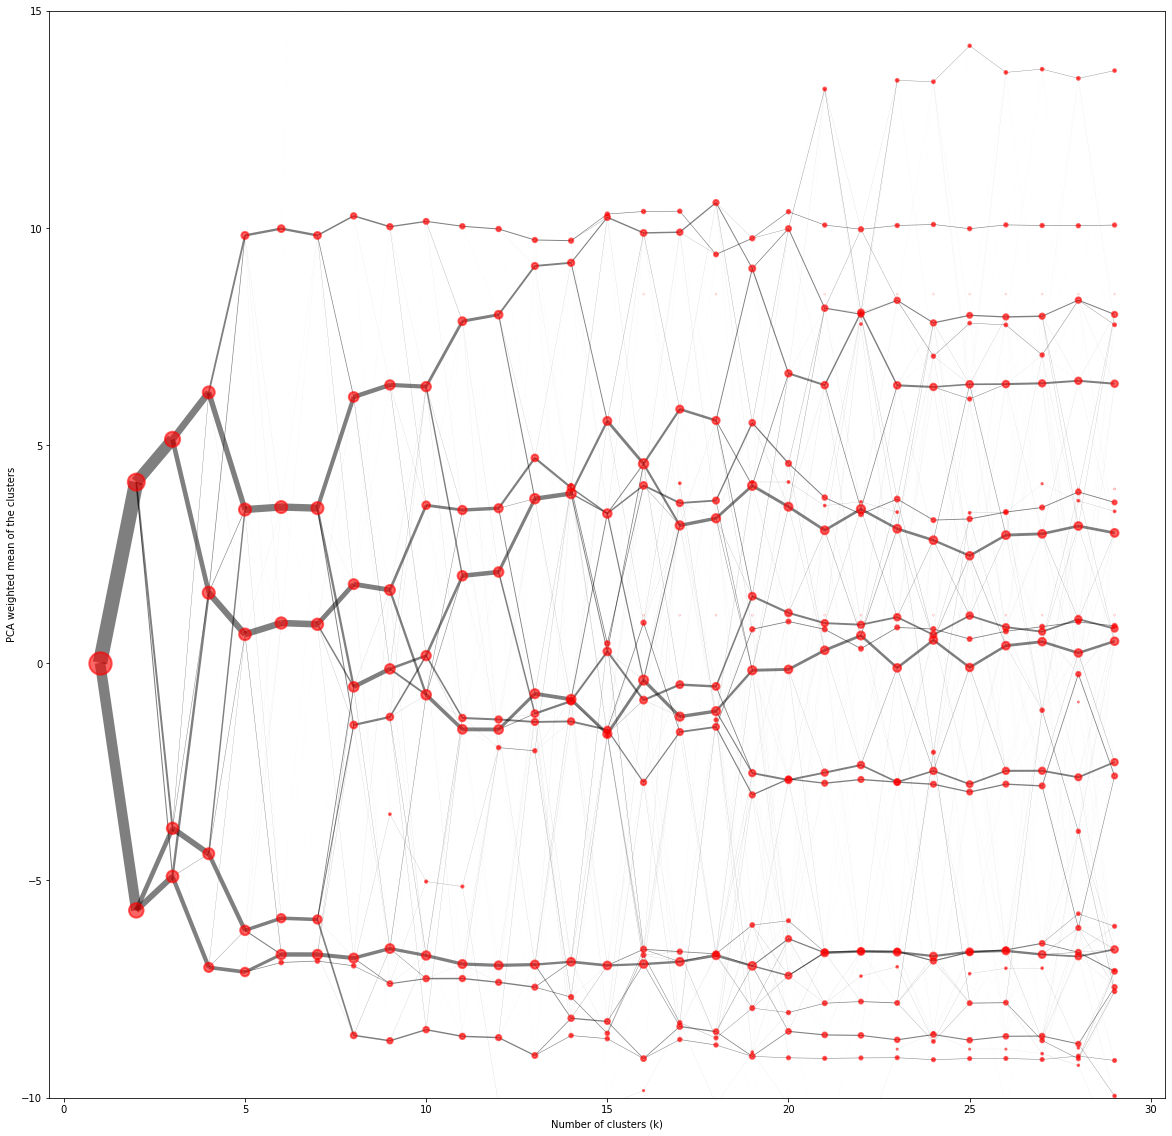

In [8]:
ax = cg_form.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-10, 15)

Based on the clustergram, we can assume that 11 clusters is the optimal number. 11 is the first point after all major branching happens and the situation stabilizes.

Before proceeding, we also save clustergam object to a file.

In [9]:
with open(folder + 'clustergram_form.pickle','wb') as f:
    pickle.dump(cg_form, f)

Let's see how 11 clusters based on form look like spatially.

In [10]:
%time km_form = KMeans(n_clusters=11, n_init=100).fit(data)

CPU times: user 2h 3min 54s, sys: 17min 19s, total: 2h 21min 13s
Wall time: 17min 17s


In [11]:
tess['clusters_form'] = km_form.labels_

We can plot the labels based on tessellation or based on buildings, each providing different insights.

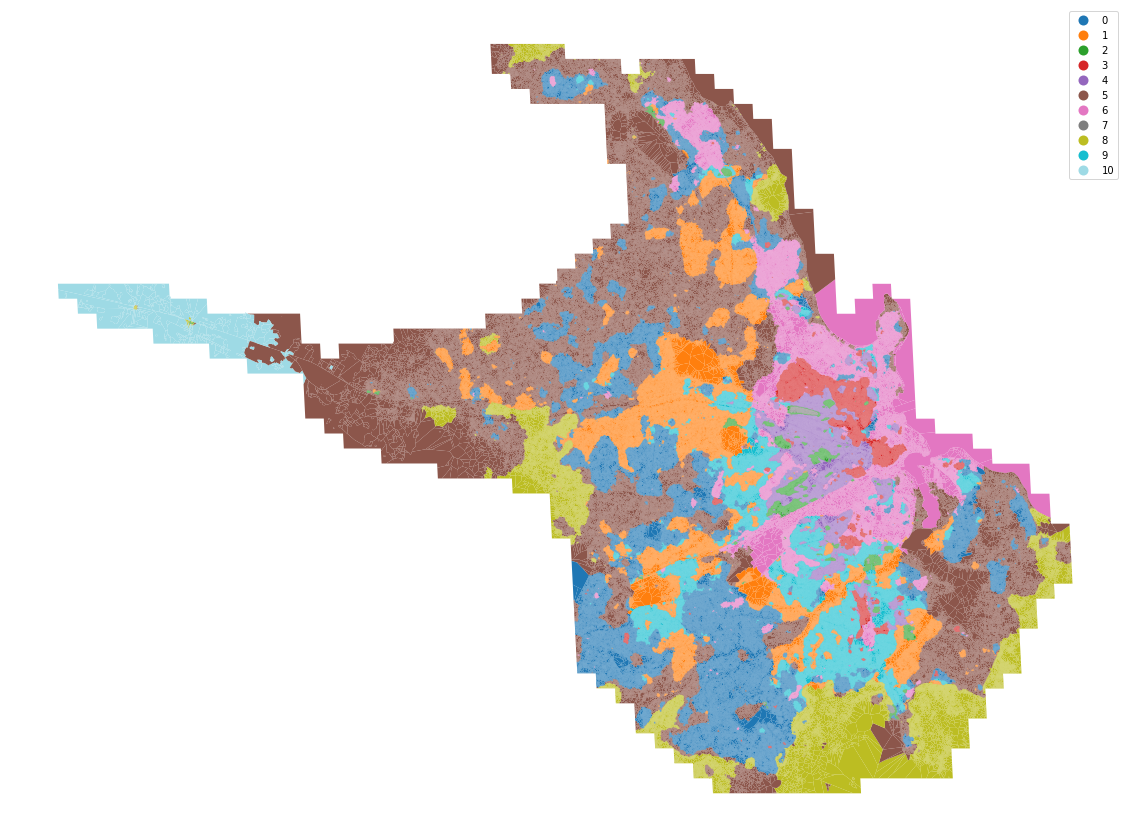

In [12]:
ax = tess.plot('clusters_form', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

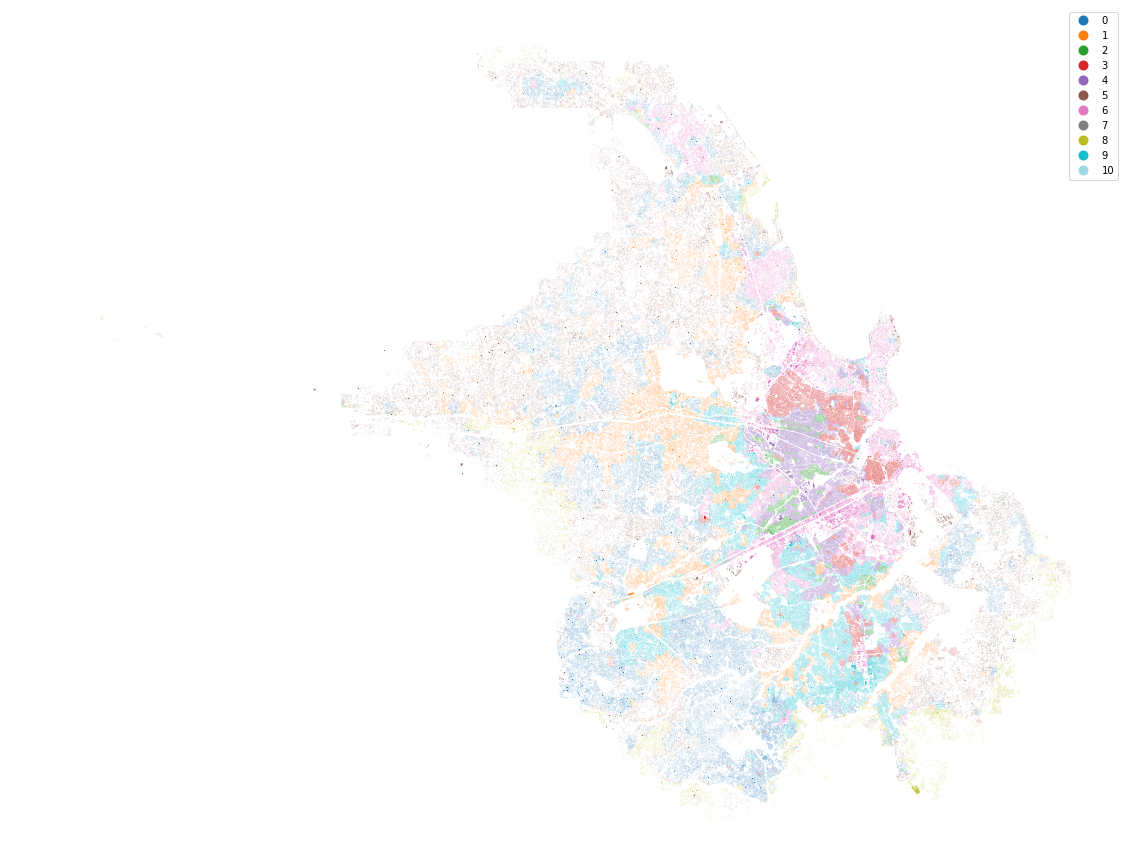

In [13]:
ax = tess.set_geometry('buildings').plot('clusters_form', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

### 3.2. Function

Clustering based on function uses only data on function, which we need to prepare. We first join all data together.

In [19]:
population = pd.read_parquet(folder + "population/population.pq")
land_cover = pd.read_parquet(folder + "land_cover/land_cover.pq")
night_lights = pd.read_parquet(folder + "night_lights/night_lights.pq")
ndvi = pd.read_parquet(folder + "ndvi.pq")

In [20]:
function_data = population.merge(land_cover, on='tID').merge(night_lights, on='tID')

In [21]:
function_data['ndvi'] = ndvi.ndvi.values

In [22]:
function_data = function_data.set_index('tID')
function_data

population  land_cover  lights      ndvi
tID                                              
0         96.060898        50.0   23.49  0.137347
1         89.316628        50.0   23.49  0.230215
2         87.038872        50.0   23.49  0.277036
3         87.038872        50.0   23.49  0.389978
4         86.569374        50.0   23.49  0.372431
...             ...         ...     ...       ...
1168891   81.500267        20.0   33.75  0.413103
1168892   79.141024        20.0   33.75  0.470519
1168893   82.881916        20.0   33.75  0.498046
1168894   80.255351        20.0   33.75  0.492762
1168895   12.635864       126.0    3.99  0.452588

[1168896 rows x 4 columns]

We have some categorical values, so we have to encode them as boolean dummies.

In [23]:
land = pd.get_dummies(function_data.land_cover)

Continuous values need to be standardized.

In [11]:
scaler = preprocessing.StandardScaler()
f_data = scaler.fit_transform(function_data.drop(columns=["land_cover"]))

We can all merge back together.

In [12]:
f_data = np.hstack([f_data, land.values])

In [29]:
f_data.shape

(1168896, 16)

In [30]:
np.isnan(f_data).any().any()

False

We are using clustergram again.

In [31]:
cg_function = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_function.fit(f_data)

PCA computed in 2.2545342445373535 seconds.
K=1 fitted in 1.2844197750091553 seconds.
K=2 fitted in 2.7105469703674316 seconds.
K=3 fitted in 5.104195594787598 seconds.
K=4 fitted in 6.409515619277954 seconds.
K=5 fitted in 8.71783185005188 seconds.
K=6 fitted in 13.041243314743042 seconds.
K=7 fitted in 15.236485004425049 seconds.
K=8 fitted in 16.622711896896362 seconds.
K=9 fitted in 25.22173500061035 seconds.
K=10 fitted in 31.26101064682007 seconds.
K=11 fitted in 35.01960730552673 seconds.
K=12 fitted in 35.51231575012207 seconds.
K=13 fitted in 43.99436616897583 seconds.
K=14 fitted in 40.28325915336609 seconds.
K=15 fitted in 45.70191526412964 seconds.
K=16 fitted in 47.9129536151886 seconds.
K=17 fitted in 57.398313999176025 seconds.
K=18 fitted in 65.83624958992004 seconds.
K=19 fitted in 60.56449866294861 seconds.
K=20 fitted in 78.49006748199463 seconds.
K=21 fitted in 78.68227291107178 seconds.
K=22 fitted in 71.40852665901184 seconds.
K=23 fitted in 107.72213530540466 sec

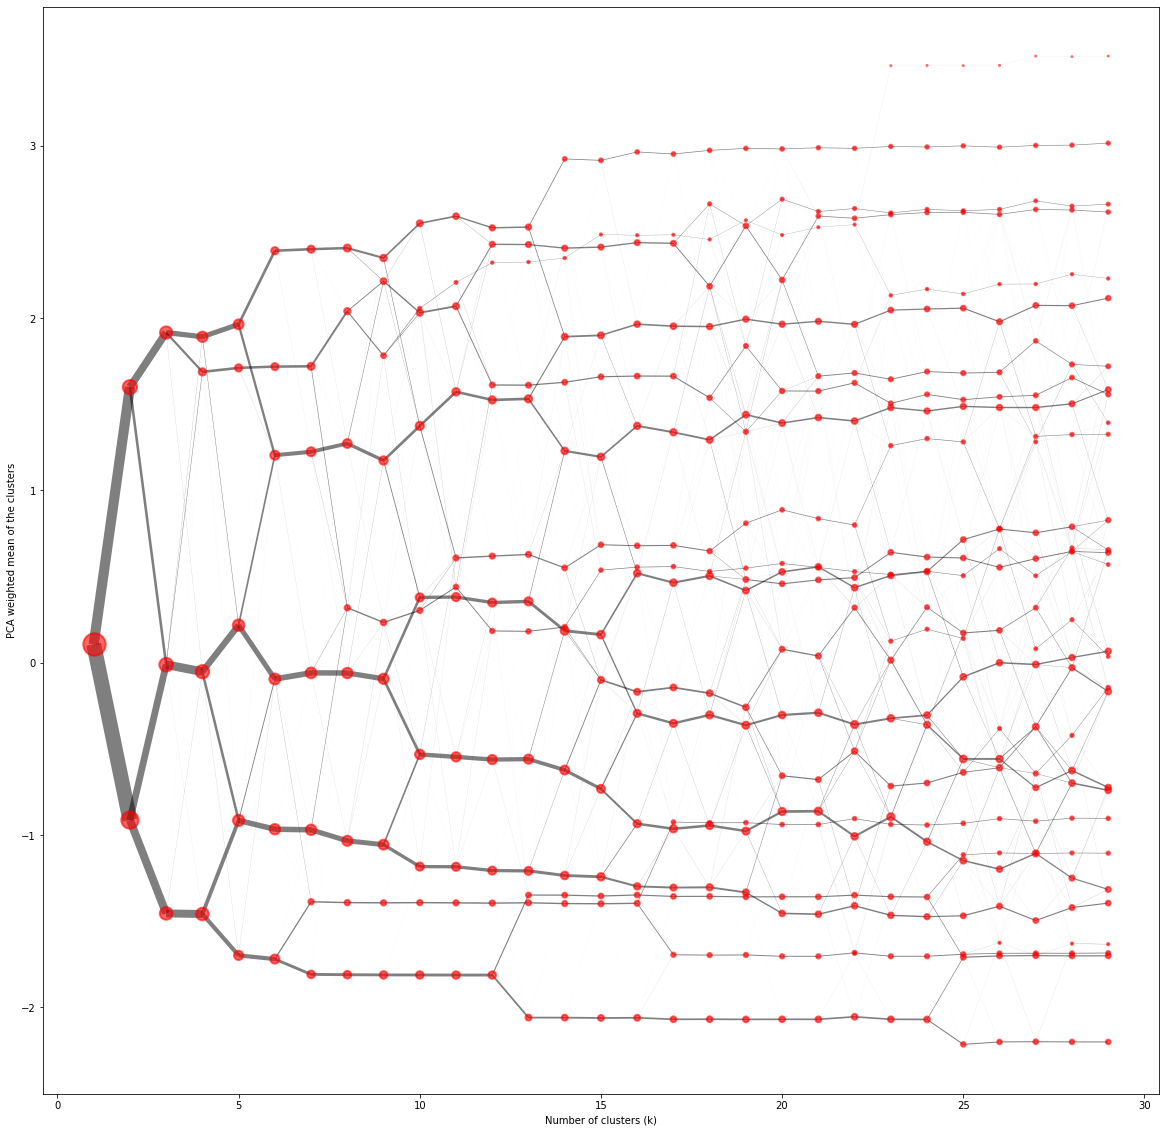

In [32]:
ax = cg_function.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})

Clustergram should be saved to a file.

In [33]:
with open(folder + 'clustergram_function.pickle','wb') as f:
    pickle.dump(cg_function, f)

We can interpret the diagram as 10 clusters being the optimum.

The figures below show 10 clusters.

In [34]:
km_function = KMeans(n_clusters=10, n_init=100).fit(f_data)

In [35]:
tess['clusters_function'] = km_function.labels_

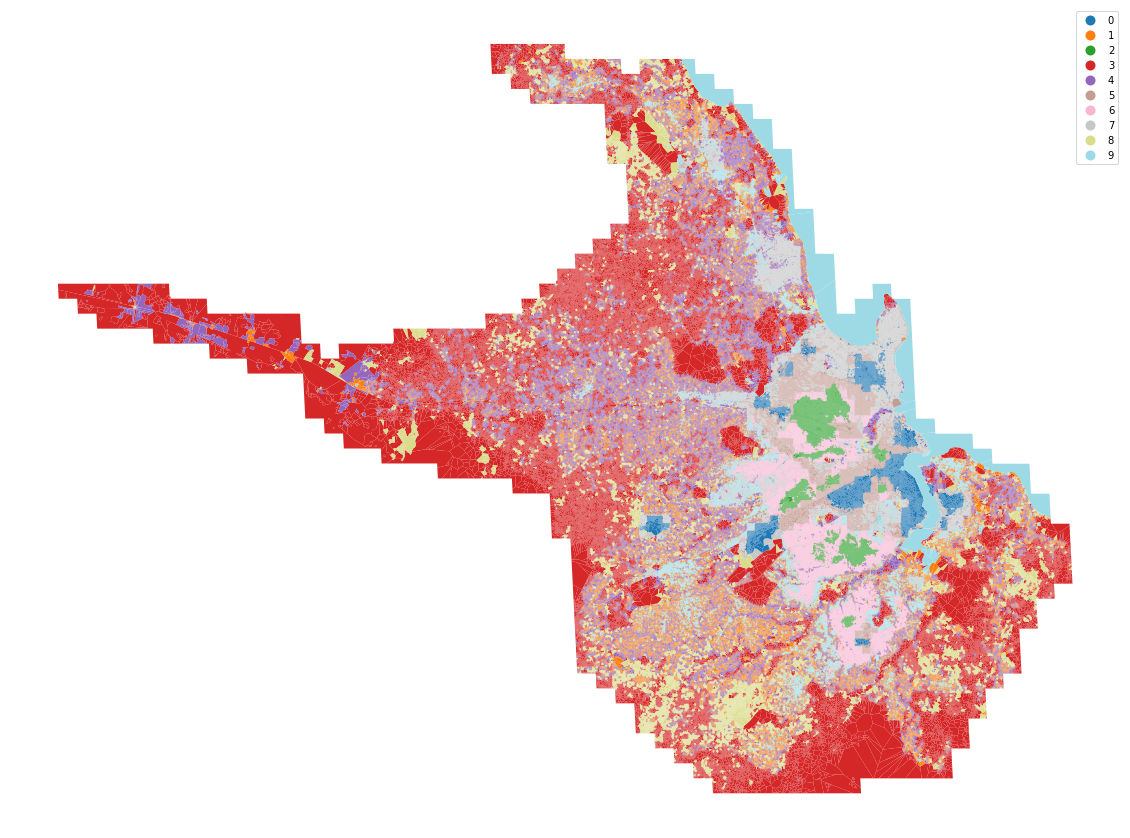

In [36]:
ax = tess.plot('clusters_function', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

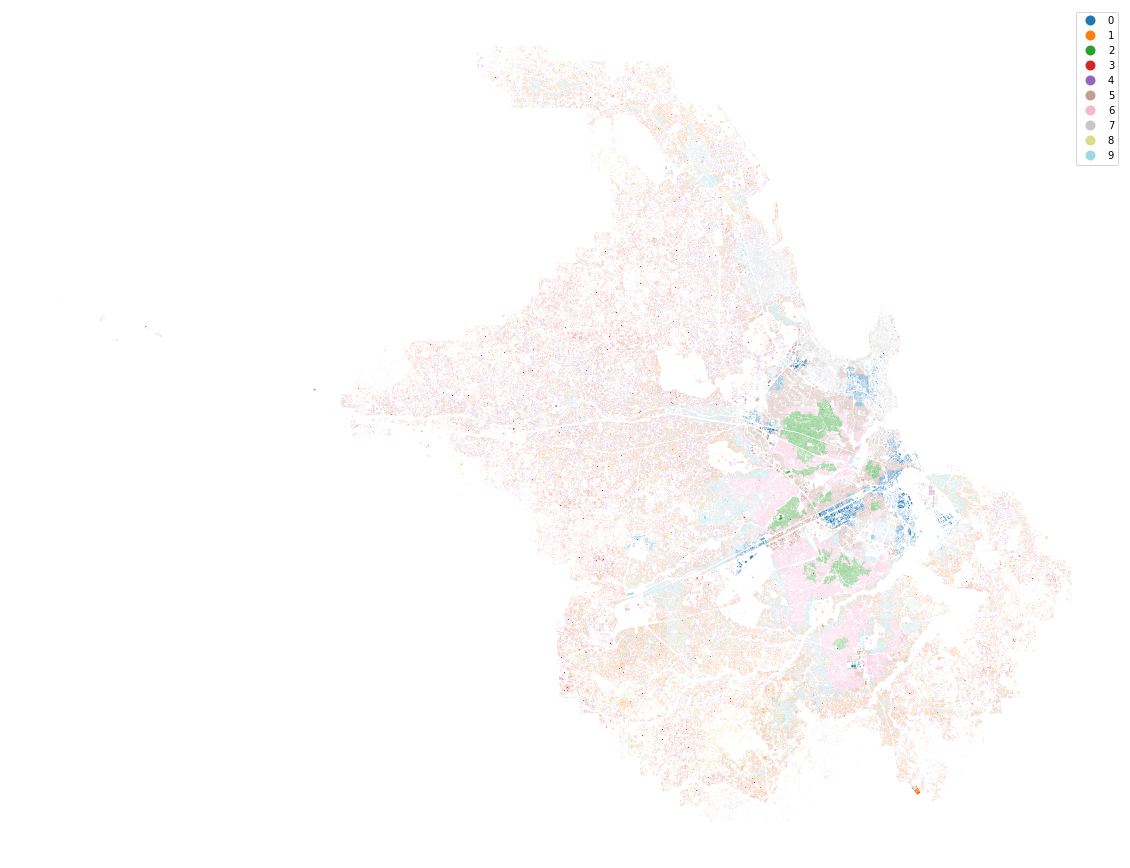

In [37]:
ax = tess.set_geometry('buildings').plot('clusters_function', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

### 3.3. Spatial Signatures

Final clustering combines both form and function into a singular classification.

First we stack both preprocessed arrays together and then run clustergram.

In [13]:
ss_data = np.hstack([data, f_data])

In [25]:
cg_ss = Clustergram(range(1, 30), n_init=10, random_state=0)
cg_ss.fit(ss_data)

K=1 skipped. Mean computed from data directly.
K=2 fitted in 13.852209568023682 seconds.
K=3 fitted in 32.72273564338684 seconds.
K=4 fitted in 54.8843469619751 seconds.
K=5 fitted in 47.96949291229248 seconds.
K=6 fitted in 56.33445167541504 seconds.
K=7 fitted in 68.59361577033997 seconds.
K=8 fitted in 77.23995614051819 seconds.
K=9 fitted in 88.71612238883972 seconds.
K=10 fitted in 112.81131887435913 seconds.
K=11 fitted in 119.01211643218994 seconds.
K=12 fitted in 135.30965542793274 seconds.
K=13 fitted in 138.7579529285431 seconds.
K=14 fitted in 141.79911613464355 seconds.
K=15 fitted in 133.8054280281067 seconds.
K=16 fitted in 137.84747219085693 seconds.
K=17 fitted in 153.21085286140442 seconds.
K=18 fitted in 151.39014339447021 seconds.
K=19 fitted in 169.06777811050415 seconds.
K=20 fitted in 182.31369829177856 seconds.
K=21 fitted in 192.9229815006256 seconds.
K=22 fitted in 180.52936363220215 seconds.
K=23 fitted in 200.63287377357483 seconds.
K=24 fitted in 270.6950440

In [26]:
c = ugg.COLORS

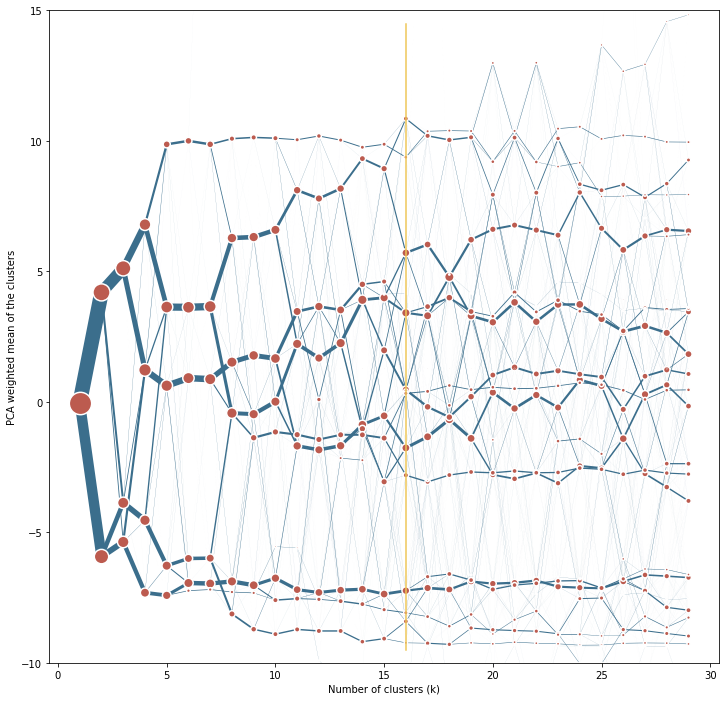

In [29]:
ax = cg_ss.plot(
    figsize=(12, 12),
    linewidth=0.5,
    cluster_style={"edgecolor": "w", "color": c[2], "linewidth": 1.5},
    size=1,
    line_style={"color":c[1]},
    pca_kwargs=dict(random_state=0),
)
ax.set_ylim(-10, 15)
ax.axvline(16, color=c[4], ymin=.02, ymax=.98)
plt.savefig(folder + "cgram.png", dpi=300, bbox_inches="tight")

In [30]:
cg_labels = cg_ss.labels
cg_labels.columns = cg_labels.columns.astype(str)
cg_labels.to_parquet(folder + 'clustergram_ss_labels.pq')

The optimal number in this case seems to be 17 clusters. We run final clustering with 1000 initiazations and fixed random state for reproducibility.

In [31]:
%time km = KMeans(n_clusters=16, n_init=1000, random_state=12345).fit(ss_data)

CPU times: user 1d 2h 10min 6s, sys: 31min 51s, total: 1d 2h 41min 57s
Wall time: 4h 1min 54s


In [35]:
tess['clusters'] = km.labels_

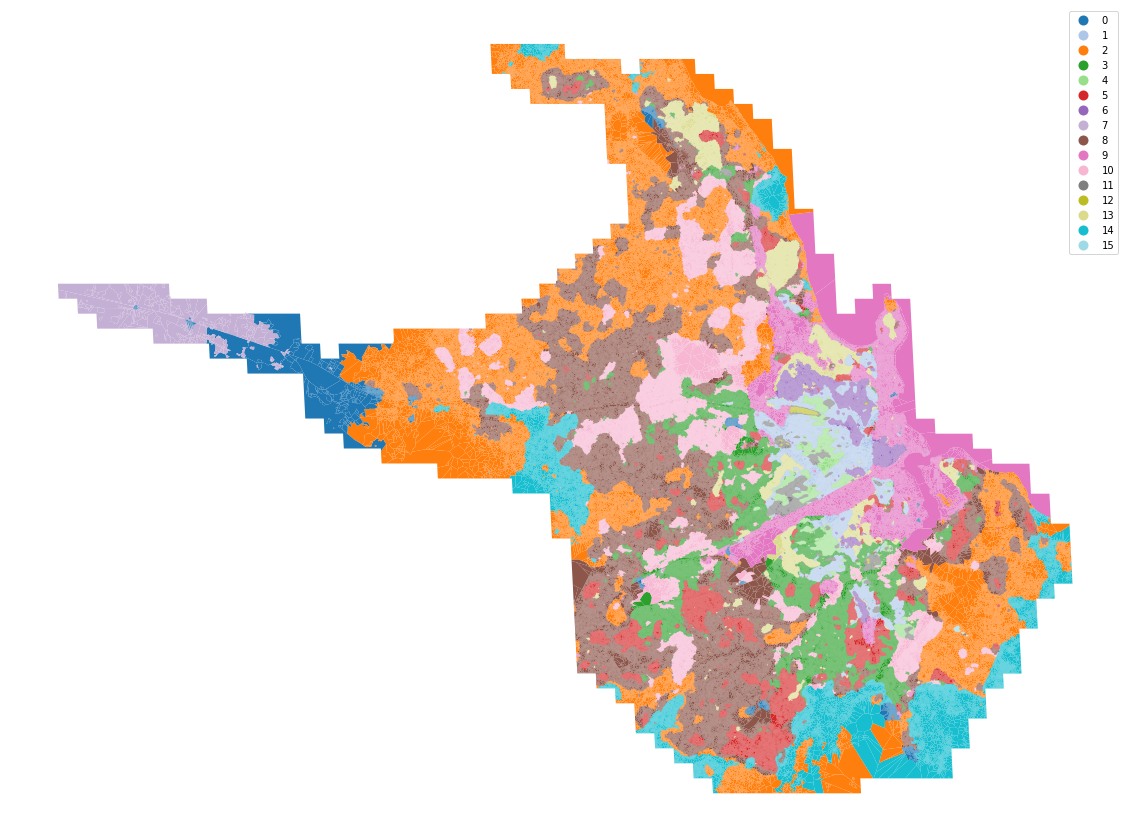

In [36]:
ax = tess.plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

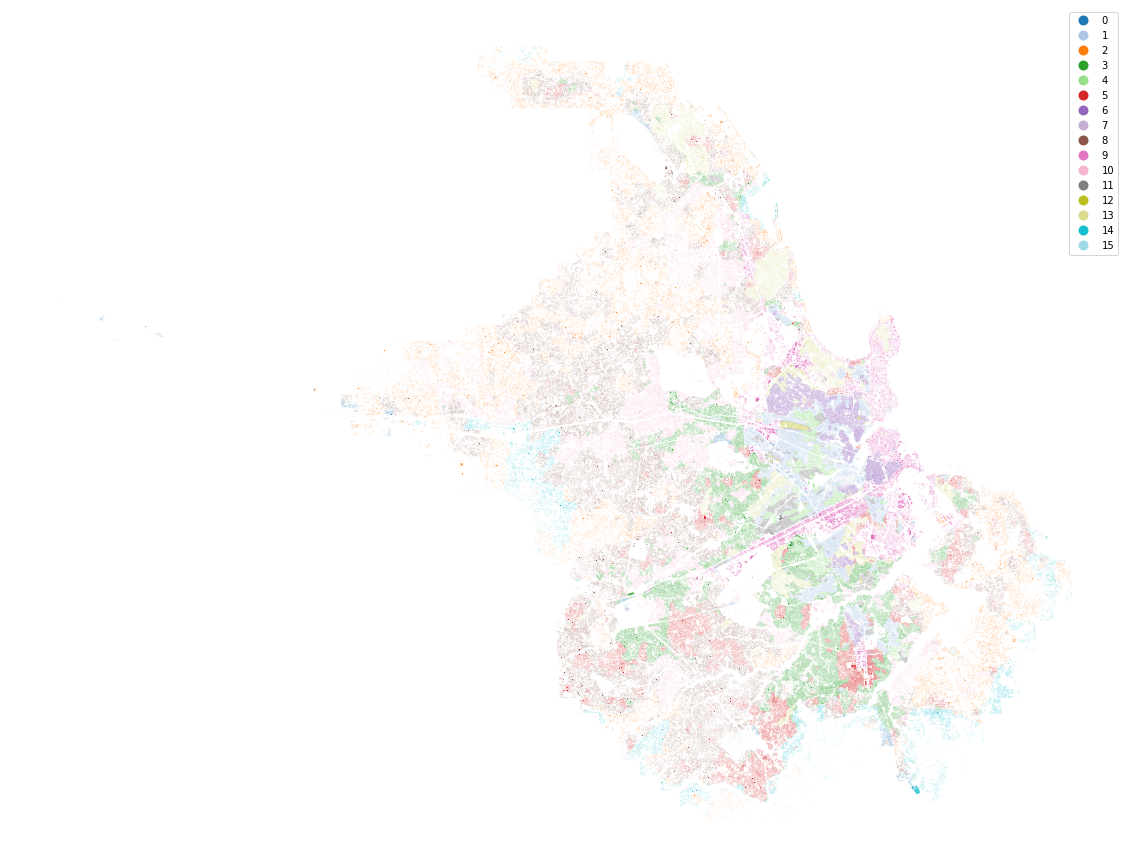

In [37]:
ax = tess.set_geometry('buildings').plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [47]:
tess[['tID', 'clusters', 'clusters_form', 'clusters_function']].to_parquet(folder + "cluster_labels.pq")

In [38]:
tess[['tID', 'clusters']].to_parquet(folder + "FINAL_cluster_labels_v2.pq")

#### Generate signatures

As a final step, we can generate a geometry representing spatial singatures as a combination of contiguous tessellation cells belonging to a single cluster. Since we have to dissolve a large number of polygons, we use dask_geopandas to parallelize the procedure.

First we create a local cluster.

In [8]:
client = Client(LocalCluster(n_workers=16))
client

<Client: 'tcp://127.0.0.1:43505' processes=16 threads=16, memory=125.55 GiB>

We read only 'tessellation' columns and cluster labels. The resulting geometry will not be enclosed tessellation anymore so we can already rename it to generic "geometry".

In [9]:
tess = gpd.read_parquet(folder + "tess.pq", columns=['tessellation']).rename_geometry("geometry")
clusters = pd.read_parquet(folder + "FINAL_cluster_labels_v2.pq")

In [10]:
tess['cluster'] = clusters.clusters.values

`dask_dissolve` mimics the behaviour of `geopandas.dissolve`, just based on parallel implementation using `dask-geopandas`.

In [11]:
%%time
ddf = dask_geopandas.from_geopandas(tess.sort_values('cluster'), npartitions=64)
final = dask_dissolve(ddf, by='cluster').compute()

CPU times: user 1min 25s, sys: 21.3 s, total: 1min 47s
Wall time: 5min 29s


<AxesSubplot:>

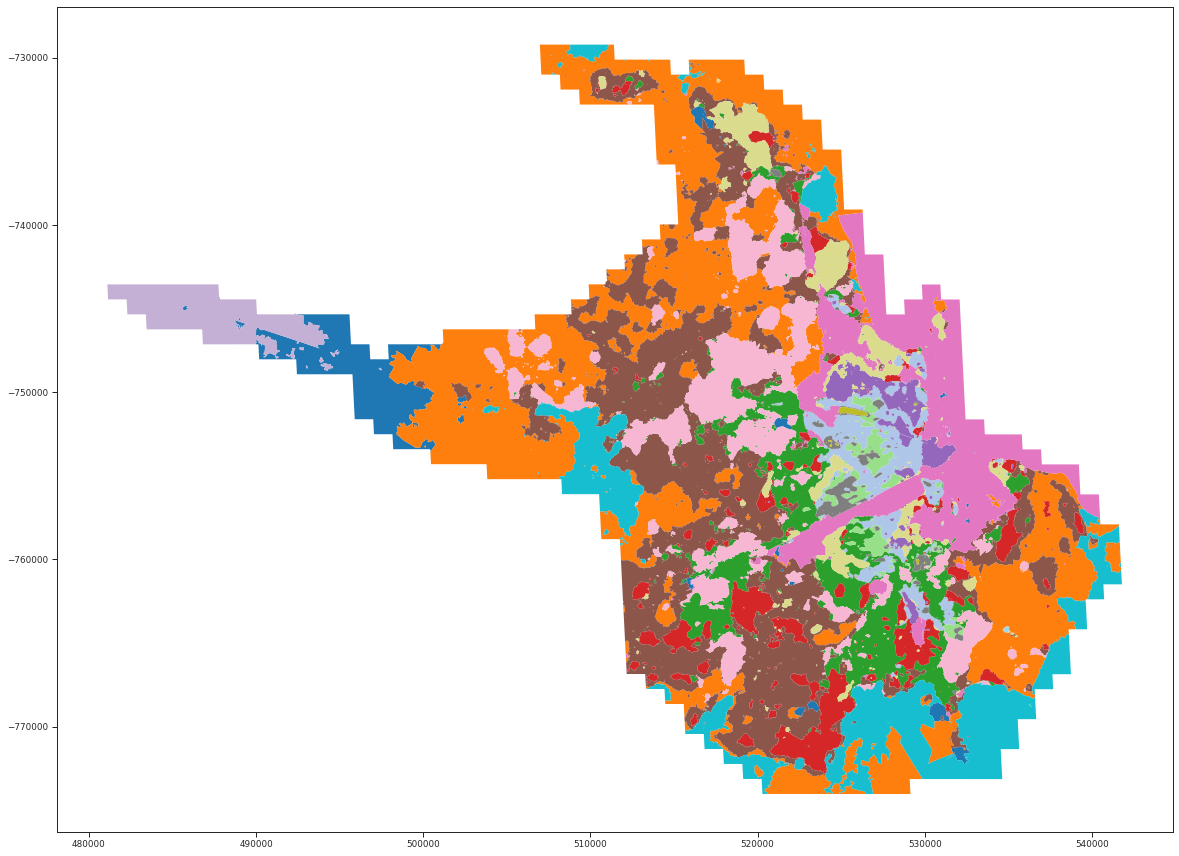

In [12]:
final.plot('cluster', categorical=True, figsize=(20, 20), cmap='tab20')

Finally, we explode the geometries to get multiple singatures of the same kind instead of a single multipolygon. (The intial `reset_index` is here to avoid bug in geopandas.)

In [13]:
final.reset_index(drop=True).explode().reset_index(drop=True).to_parquet(folder + "signatures.pq")

/tmp/ipykernel_6247/3199231112.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  final.reset_index(drop=True).explode().reset_index(drop=True).to_parquet(folder + "signatures.pq")
/tmp/ipykernel_6247/3199231112.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  final.reset_index(drop=True).explode().reset_index(drop=T

Before we end, we close dask client.

In [14]:
client.close()

## 4. Figures

Finally, we create final figures.

In [6]:
final = gpd.read_parquet(folder + "signatures.pq")

In [7]:
enc = gpd.read_parquet(folder + "enclosures.pq")

In [4]:
sns.set(context="paper", style="ticks", rc={'patch.force_edgecolor': False})

In [9]:
cmap = ugg.get_colormap(final.cluster.nunique(), randomize=False)

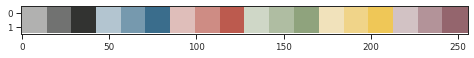

In [10]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(figsize=(8, .5))
ax.imshow(gradient, aspect='auto', cmap=cmap)

In [6]:
cols = cmap.colors
symbology = {0: cols[9],
             1: cols[8],
             2: cols[7],
             3: cols[11],
             4: cols[6],
             5: cols[10],
             6: cols[5],
             7: cols[12],
             8: cols[3],
             9: cols[14],
             10: cols[17],
             11: cols[13],
             12: cols[16],
             13: cols[1],
             14: cols[0],
             15: cols[15],
             16: cols[4],
             17: cols[2]
            }

In [12]:
df = final.set_crs(enc.crs).to_crs(3857)

In [ ]:
token = ""

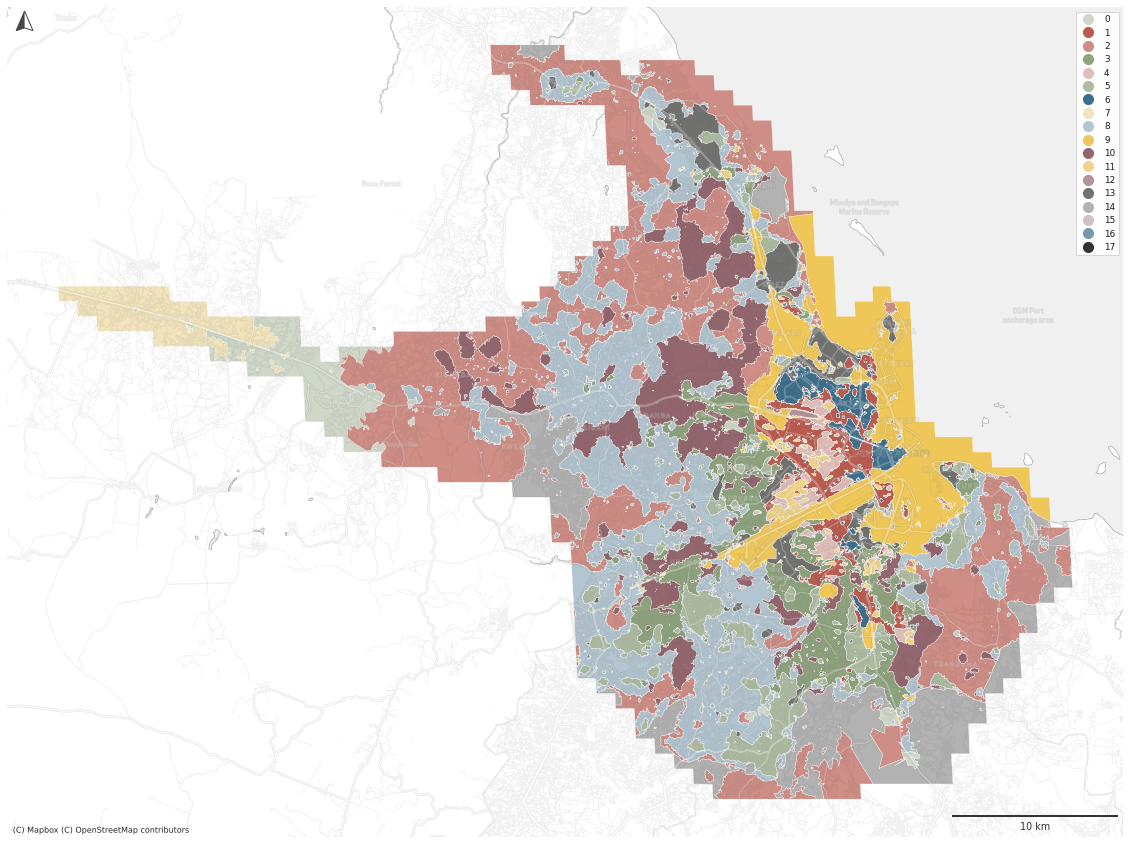

In [14]:
ax = df.plot(color=df['cluster'].map(symbology), figsize=(20, 20), zorder=1, linewidth=.3, edgecolor='w', alpha=1)
contextily.add_basemap(ax, crs=df.crs, source=ugg.get_tiles('roads', token), zorder=2, alpha=.3, zoom=12)
# contextily.add_basemap(ax, crs=df.crs, source=ugg.get_tiles('labels', token), zorder=3, alpha=1, zoom=12)
contextily.add_basemap(ax, crs=df.crs, source=ugg.get_tiles('background', token), zorder=-1, alpha=1, zoom=12)
ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    color=ugg.COLORS[0],
                    location='lower right',
                    height_fraction=0.002,
                    pad=.5,
                    frameon=False,
                    )
ax.add_artist(scalebar)

ugg.north_arrow(plt.gcf(), ax, 0, size=.026, linewidth=1, color=ugg.COLORS[0], loc="upper left", pad=.002, alpha=.9)

from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in symbology.values()]
leg_points = ax.legend(custom_points, symbology.keys(), loc='upper right', frameon=True)
ax.add_artist(leg_points)
plt.savefig(folder + "signatures.png", dpi=300, bbox_inches="tight")

In [ ]:
tess = gpd.read_parquet(folder + "tess.pq").set_geometry('buildings')
clusters = pd.read_parquet(folder + "FINAL_cluster_labels.pq")
tess['cluster'] = clusters.clusters.values

In [ ]:
ax = tess.to_crs(3857).plot(color=tess['cluster'].map(symbology), figsize=(20, 20), zorder=1, alpha=1)
contextily.add_basemap(ax, crs=df.crs, source=ugg.get_tiles('roads', token), zorder=2, alpha=.3, zoom=12)
contextily.add_basemap(ax, source=ugg.get_tiles('labels', token), zorder=3, alpha=1, zoom=12)
contextily.add_basemap(ax, source=ugg.get_tiles('background', token), zorder=-1, alpha=1, zoom=12)
ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    color=ugg.COLORS[0],
                    location='lower right',
                    height_fraction=0.002,
                    pad=.5,
                    frameon=False,
                    )
ax.add_artist(scalebar)

ugg.north_arrow(plt.gcf(), ax, 0, size=.026, linewidth=1, color=ugg.COLORS[0], loc="upper left", pad=.002, alpha=.9)

from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in symbology.values()]
leg_points = ax.legend(custom_points, symbology.keys(), loc='upper right', frameon=True)
ax.add_artist(leg_points)
plt.savefig(folder + "signatures_buildings.png", dpi=300, bbox_inches="tight")

In [3]:
clusters = pd.read_parquet(folder + "FINAL_cluster_labels.pq")

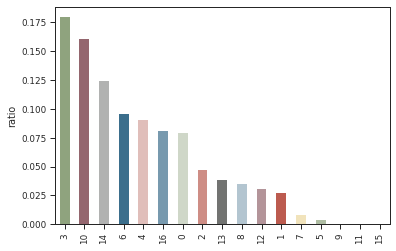

In [8]:
counts = clusters.clusters.value_counts(normalize=True)
color = counts.index.map(symbology)
counts.plot.bar(color=color)
plt.ylabel("ratio")
plt.savefig(folder + "counts.pdf", dpi=300, bbox_inches="tight")

## 5. Cluster summary

We can also export summary values of our input characters for each cluster.

In [6]:
data = pd.read_parquet(
    folder + "tess.pq", columns=characters
)

In [9]:
clusters = pd.read_parquet(folder + "FINAL_cluster_labels_v2.pq")

In [11]:
data["cluster"] = clusters.clusters.values

We get mean of each character for each cluster.

In [12]:
means = data[characters].groupby(data.cluster).mean().T

It is better to use full names as the result should be interpretable. Codes are not that useful.

In [14]:
char_names = {
    'sdbAre': 'area of building',
    'sdbPer': 'perimeter of building',
    'sdbCoA': 'courtyard area of building',
    'ssbCCo': 'circular compactness of building',
    'ssbCor': 'corners of building',
    'ssbSqu': 'squareness of building',
    'ssbERI': 'equivalent rectangular index of building',
    'ssbElo': 'elongation of building',
    'ssbCCM': 'centroid - corner mean distance of building',
    'ssbCCD': 'centroid - corner distance deviation of building',
    'stbOri': 'orientation of building',
    'sdcLAL': 'longest axis length of ETC',
    'sdcAre': 'area of ETC',
    'sscCCo': 'circular compactness of ETC',
    'sscERI': 'equivalent rectangular index of ETC',
    'stcOri': 'orientation of ETC',
    'sicCAR': 'covered area ratio of ETC',
    'stbCeA': 'cell alignment of building',
    'mtbAli': 'alignment of neighbouring buildings',
    'mtbNDi': 'mean distance between neighbouring buildings',
    'mtcWNe': 'perimeter-weighted neighbours of ETC',
    'mdcAre': 'area covered by neighbouring cells',
    'ltcWRE': 'weighted reached enclosures of ETC',
    'ltbIBD': 'mean inter-building distance',
    'sdsSPW': 'width of street profile',
    'sdsSWD': 'width deviation of street profile',
    'sdsSPO': 'openness of street profile',
    'sdsLen': 'length of street segment',
    'sssLin': 'linearity of street segment',
    'ldsMSL': 'mean segment length within 3 steps',
    'mtdDeg': 'node degree of junction',
    'lcdMes': 'local meshedness of street network',
    'linP3W': 'local proportion of 3-way intersections of street network',
    'linP4W': 'local proportion of 4-way intersections of street network',
    'linPDE': 'local proportion of cul-de-sacs of street network',
    'lcnClo': 'local closeness of street network',
    'ldsCDL': 'local cul-de-sac length of street network',
    'xcnSCl': 'square clustering of street network',
    'mtdMDi': 'mean distance to neighbouring nodes of street network',
    'lddNDe': 'local node density of street network',
    'linWID': 'local degree weighted node density of street network',
    'stbSAl': 'street alignment of building',
    'stcSAl': 'street alignment of ETC',
    'mtbSWR': 'shared walls ratio of buildings',
    'sddAre': 'area covered by node-attached ETCs',
    'sdsAre': 'area covered by edge-attached ETCs',
    'sisBpM': 'buildings per meter of street segment',
    'misCel': 'reached ETCs by neighbouring segments',
    'mdsAre': 'reached area by neighbouring segments',
    'lisCel': 'reached ETCs by local street network',
    'ldsAre': 'reached area by local street network',
    'ltcRea': 'reached ETCs by tessellation contiguity',
    'ltcAre': 'reached area by tessellation contiguity',
    'ldeAre': 'area of enclosure',
    'ldePer': 'perimeter of enclosure',
    'lseCCo': 'circular compactness of enclosure',
    'lseERI': 'equivalent rectangular index of enclosure',
    'lseCWA': 'compactness-weighted axis of enclosure',
    'lteOri': 'orientation of enclosure',
    'lteWNB': 'perimeter-weighted neighbours of enclosure',
    'lieWCe': 'area-weighted ETCs of enclosure',
    'ldbPWL': 'perimeter wall length of adjacent buildings',
    'libNCo': 'number of courtyards within adjacent buildings',
    'misRea': 'cells reached within neighbouring street segments'
}

In [16]:
means.index = means.index.map(char_names)

We do the same with function characters.

In [31]:
population = pd.read_parquet(folder + "population/population.pq")
night_lights = pd.read_parquet(folder + "night_lights/night_lights.pq")
ndvi = pd.read_parquet(folder + "ndvi.pq")

In [32]:
function = population.merge(night_lights, on='tID')

In [33]:
function['ndvi'] = ndvi.ndvi.values

In [34]:
function = function.set_index('tID')
function

population  lights      ndvi
tID                                  
0         96.060898   23.49  0.137347
1         89.316628   23.49  0.230215
2         87.038872   23.49  0.277036
3         87.038872   23.49  0.389978
4         86.569374   23.49  0.372431
...             ...     ...       ...
1168891   81.500267   33.75  0.413103
1168892   79.141024   33.75  0.470519
1168893   82.881916   33.75  0.498046
1168894   80.255351   33.75  0.492762
1168895   12.635864    3.99  0.452588

[1168896 rows x 3 columns]

In [35]:
f_means = function.groupby(data.cluster.values).mean().T

In [38]:
f_means.index = ["population", "night lights", "NDVI"]

Finally, we join form and function summaries and plot the final output as a styled pandas DataFrame.

In [39]:
together = means.append(f_means)

In [40]:
together.style.format('{:.2f}').background_gradient(cmap=sns.diverging_palette(235, 16, 60, 55, as_cmap=True) ,axis=1,)

## Create a data product

Create files to be uploaded to figshare for public access. We need the raw measured data on ET level and signature geometry.

In [4]:
form = gpd.read_parquet(
    folder + "tess.pq",
)

In [5]:
conv = pd.read_parquet(folder + "convolutions.pq")

In [6]:
population = pd.read_parquet(folder + "population/population.pq")
night_lights = pd.read_parquet(folder + "night_lights/night_lights.pq")
ndvi = pd.read_parquet(folder + "ndvi.pq")
function = population.merge(night_lights, on='tID')
function['ndvi'] = ndvi.ndvi.values
function = function.set_index('tID')

In [7]:
combined = pd.concat([form, conv, function], axis=1)

In [8]:
clusters = pd.read_parquet(folder + "FINAL_cluster_labels_v2.pq")

In [9]:
combined["signature_type"] = clusters.clusters.values

In [10]:
combined.to_parquet(folder + "dar_es_salaam_data.parquet")

In [11]:
sig = gpd.read_parquet(folder + "signatures.pq")

In [12]:
sig.crs = combined.crs

In [13]:
sig = sig.rename(columns={"cluster":"signature_type"})

In [14]:
sig.to_parquet(folder + "signatures.pq")